# AEP Energy Forecasting with XGBoost

This notebook forecasts hourly electricity consumption (in megawatts) using data from American Electric Power (AEP). The project applies XGBoost, a gradient boosting framework, for time series regression and evaluates model performance on unseen data.

## Project Goals

- Understand and implement XGBoost for time series forecasting.
- Engineer time-based features to improve model accuracy.
- Evaluate model performance using RMSE.
- Analyze best/worst predictions and propose next steps.

## Methodology Overview

1. **Data Preparation**: Load and clean the AEP dataset, ensure datetime format is set correctly
2. **Feature Engineering**: Create time-based features (hour, day of week, etc.) for model input.
3. **Train-Test Split**: Divide data based on a cutoff date (pre-2015 as training, post-2015 as testing).
4. **Modeling**: Using XGBoost Regression from `xgboost` to model energy demand.
5. **Evaluation**: Calculate RMSE and analyze the model's best/worst predictions.

# Time Series Forecasting with XGBoost

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load and preprocess the data
df = pd.read_csv('AEP_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

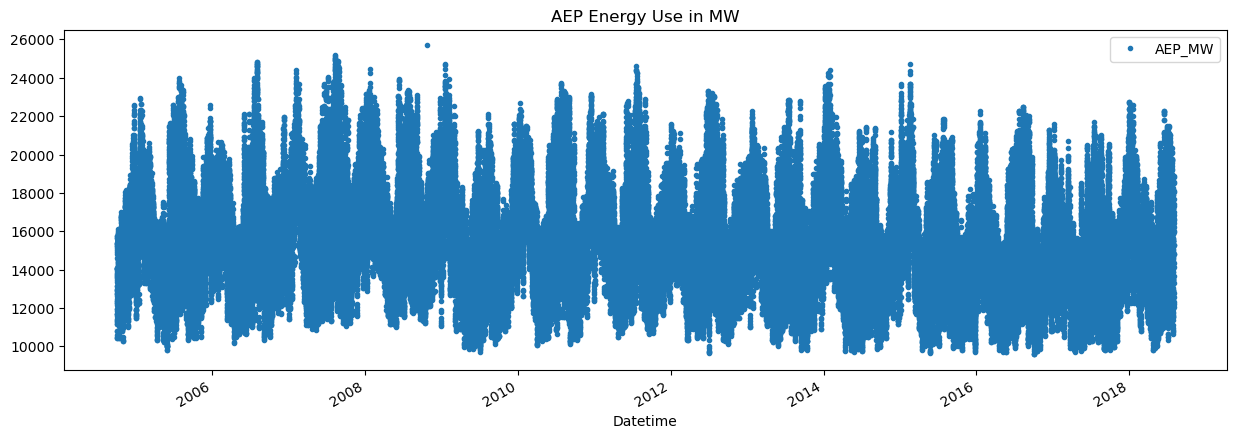

In [25]:
# Plotting the raw energy usage over time
color_pal = sns.color_palette()
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AEP Energy Use in MW')
plt.show();

The scatter plot of hourly energy usage for American Electric Power (AEP) reveals sevearl important characteristics of the time series:

- **Seasonality**: There is a strong annual cycle with recurring peaks and throughs, likely reflecting seasonal variations in electricity demand - higher usage during summer and winter due to heating and cooling needs.
- **Trend**: The overall trend appears relatively stable, with no significant upward or downward movement across the years. However, slight fluctuations in peak demand can be seen, possibly due to population changes, economic factors, or energy efficiency improvements.
- **Variance**: The amplitude of energy consumption varies throughout the year, with broader peaks during extreme seasons and tighter distributions during milder periods.
- **Data Quality**: The plot does not show major gaps or anomalies, indicating the dataset is relatively clean.

This initial visualization confirms that time series forecasting models - especially those capable of capturing seasonality like XGBoost with engineered features - will be appropriate for this dataset.

# Train/Test Split

To evaluate forecasting performance, the dataset was split into training and testing sets based on a time threshold of **January 1st, 2015**.

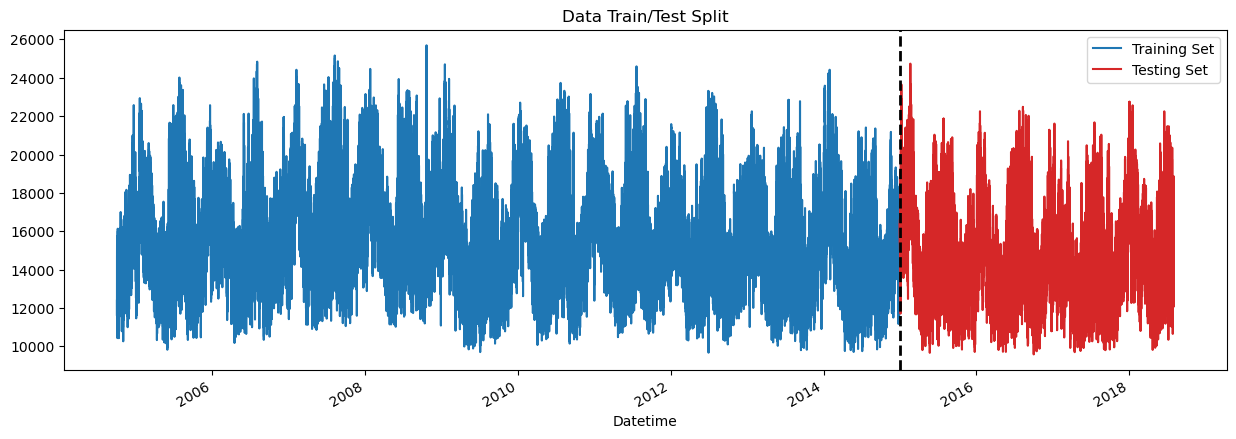

In [26]:
split_date = pd.to_datetime('2015-01-01')
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax = ax,
           label = 'Training Set',
           color = 'tab:blue')
test.plot(ax = ax,
          label = 'Test Set',
          color = 'tab:red')
ax.axvline(split_date, 
           color = 'black',
           ls = '--',
           linewidth = 2)
ax.set_title('Data Train/Test Split')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

As shown in the first plot, the training set (blue) spans from 2004 to the end of 2014, while the testing set (red) includes data from 2015 through 2018. This approaches ensures the model is trained solely on historical data and evaluated on future, unseen data - an essential practice in time series forecasting to avoid data leakage. The split also preserves seasonality and trend patterns in both sets, allowing the model to generalize better across time.

## Weekly Pattern Inspection

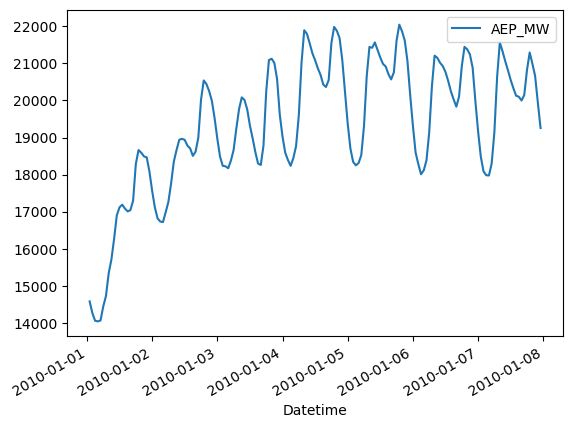

In [27]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot();

The second plot zooms into one week of data from **January 1-8, 2010**, revealing clear **daily ciclic behavior** in energy consumption. Demand tends to rise during the day and fall overnight, which is expected for energy usage patterns driven by human activity.

These short-term cycles emphasize the importance of incorporating **hour of day** and **day of week** features when training models like XGBosst, which benefit from engineered time-based predictors rather than assuming temporal continuity. 

# Feature Creation

In [28]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [29]:
df = create_features(df)

In this step, we generate **time-based features** from the datetime index to help the model capture important patterns in energy usage. Since algorithms like XGBoost do not natively understand temporal structure, manually adding these features allows the model to learn relationships tied to calendar cycles and time of day.

The features created include:

- **Hour** - captures daily patterns (e.g., peak demand during work hours)
- **Day of Week** - distinguishes weekdays from weekends, which often show different usage behavior
- **Quater and Month** - reflect seasonal effects, such as increased usage in summer and winter
- **Year** - allows the model to track long-term trends or shifts in energy policy or efficiency
- **Day of Year** - provides a continuous annual progression, useful for detecting seasonality with finer resolution

This engineered feature set enriches the dataset and equips tree-based models with meaningful variables to improve predictive performance.

# Visualize our Feature

To better understand the behavior of energy demand over time, we visualize the distribution of `AEP_MW` by **hour of day** and **month of year** using boxplots.

## MW by Hour

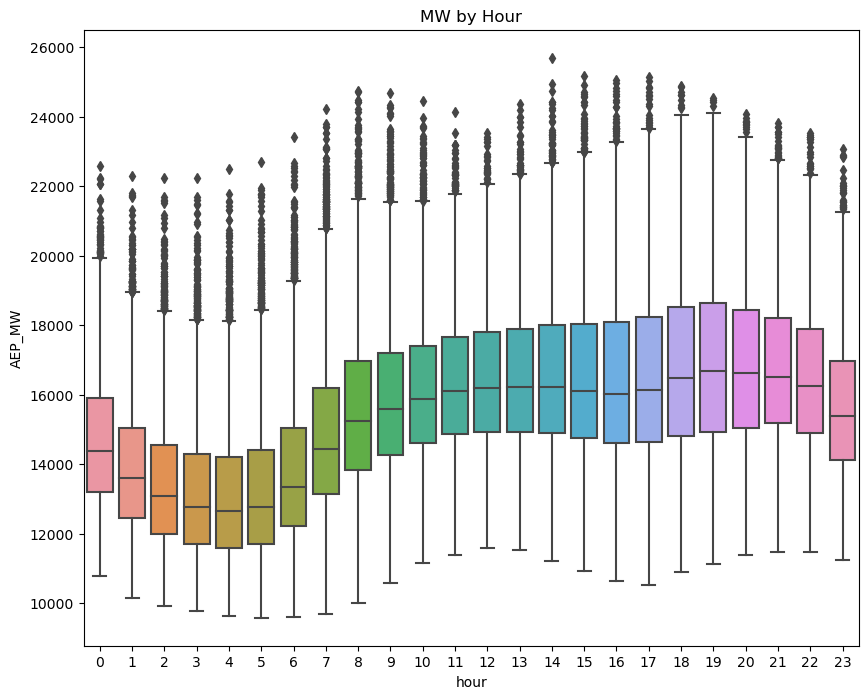

In [30]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df,
            x = 'hour',
            y = 'AEP_MW')
ax.set_title('MW by Hour');

The first boxplot reveals a clear **daily usage pattern**:

- **Demand is lowest** between **2 AM and 6 AM**, when most people are asleep.
- Energy usage **steadily increases in the morning**, peaking between **5 PM and 8 PM**, likely due to residual and commerical activity during evening hours.
- After 9 PM, demand gradually declines again.

This diurnal trend confirms that **hour** is a highly informative feature for forecasting short-term energy usage.

## MW by Month

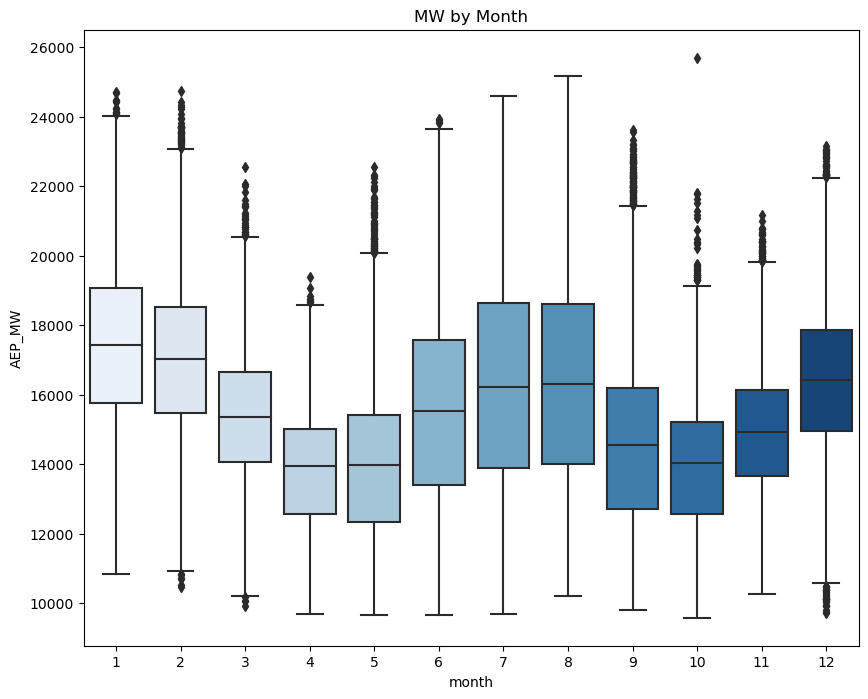

In [31]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df,
            x = 'month',
            y = 'AEP_MW',
           palette = 'Blues')
ax.set_title('MW by Month');

The second boxplot shows strong **seasonal variation**:

- **Peak demand occurs in January and August**, which correspond to winter and summer -periods of high heating and cooling needs.
- **Demand dips in spring (April/May)** and **fall (October/November)**, where temperatures are milder and energy consumption is lower.
- There's also **greater variability in summer and winter**, suggesting extreme weather can significantly impact hourly energy demand.

These observations validate the importance of including month and other seasonal indicators (like quater or day of year) in the feature set of effective time series modeling.

# Model Training and Evaluation

In this section, we train an **XGBoost regression model** to forecast hourly electricity demand using the engineered time-based features. The model leverages six predictors (`hour`, `dayofweek`, `quarter`, `month`, `year`, and `dayofyear`) to capture both short-term cycles and long-term trends in energy usage.

**Model Details:**

- **Model Type**: `XGBRegressor`, a powerful gradient boosting model known for high predictive accuracy on structured/tabular data.
- **Parameters**:
    - `n_estimators = 1000`: Train up to 1000 trees
    - `learning_rate = 0.01`: Use a slow learning rate for gradual optimization
    - `early_stopping_rounds = 50`: Stop training if validation performance doesn't improve for 50 rounds (prevents overfitting)

In [32]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [33]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [34]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, Y_train,
        eval_set = [(X_train, Y_train), (X_test, Y_test)],
        verbose = 100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[544]	validation_0-rmse:1091.83993	validation_1-rmse:1647.10973


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

**Training Progress:**

As seen from the training log:

- RMSE (Root Mean Squared Error) for the training set dropped steadily from **~2557 to 1091**
- RMSE for the testing set plateaued from **1644-1648**, indicating **some generalization gap**, but still good performance

The **early stopping** mechanism triggered around iteration 545, which suggests the model converged before reaching the full 1000 estimators.

**Key Takeaways:**

- The model learns strong patterns from the training data and gneralizes reasonably well to unseen data.
- The gap between training and testing RMSE suggests mild overfitting, which could be addressed further through regularization or cross-validation.
- Time-based engineered features are proving to be effective predictors without needing lag features or recursive predictions.

# Feature Importance

To interpret the trained XGBoost model, we examine the **relative importance** of each input feature based on the gain-based metric provided by the model. This gives insight into which time-based factors contribute most to accurate energy demand predictions.

In [35]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

In [ ]:
fi.sort_values('importance').plot(kind = 'barh',
                                  title = 'Feature Importance')
plt.show();

**Key Observations:**

- **Hour** is by far the most influential feature, accounting for nearly 40% of the total model importance. This reinforces the strong intra-day variation in energy use patterns, whcih aligns with the diurnal cycle of human activity and building operations.
- **Day of Week, Month**, and **Day of Year** follow with moderate importance, reflecting **weekly and seasonal usage patterns**. These variables help the model distinguish between business days, weekends, and seasonal energy demands.
- **Quater** shows slightly less influence than Month, likely due to its coarser resolution.
- **Year** contributes the least, suggesting that **long-term trends or structural changes** in the data are minimal over the span of this dataset (2004-2018).

This annalysis validates the choice of features and confirms that **temporal granularity (especially hourly data)** plays a critical role in effective short-term energy forecasting.

# Forecast on Test

After training the model, we generate predictors on the test set and compare them against the actual energy usage (`AEP_MW`). The first plot provides a **long-range view** of the entire dataset, highlighting howw the model captures general seasonal trends, espcially during the test period (2015-2018).

In [ ]:
test['prediction'] = reg.predict(X_test)

In [ ]:
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

In [ ]:
ax = df[['AEP_MW']].plot(figsize = (15, 5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
## Zommed-In Forecast (April 1-7, 2018)

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize = (15, 5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style = '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

The second plot zooms into one week of forecasted data and reveals more granular insights:

- The model successfully tracks the **daily usage cycles** but slightly underestimates the **peak demand** and overestimates during off-peak hours.
- The prediction curve is **less volatile** than the actual usage, indicating that the model is smoothing over some high-frequency fluctuations.

This behavior is expected from tree-based models like XGBoost, which are powerful at capturing structured patterns but may struggle with highly transient spikes unless enhanced with lag features or external signals.

## Model Performance

In [ ]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.4f}')

This Root Mean Squared Error (RMSE) is reasonably low, suggesting strong predictive performance especially considering the simplicity of the model (only time-based features were used).

## Opportunities for Improvement

To further enhance model accuracy:

- **Hyperparameter tuning** (eg., max_depth, subsample, colsample_bytree) using cross-validation could help reduce overfitting and improve generalization.
- **Incorporating holiday indicators** could account for abnormal usage days (e.g., Thanksgiving, Christmas), where energy consumption may spike or drop.
- **Including lagged features** (e.g., previous hour, previous day usage) would allow the model to capture autocorrelation effects often present in time series data.
- **Weather data integration** could explain temperature-dependent consumption patterns.

These additions would likely boost short-term prediction accuracy and capture more of the volatility seen in the test data.

# Error Analysis : Best and Worst Prediction Days

To futher evaluate model performance, we computed the **absolute error** between the predicted and acutal energy values on the test set. By averaging this error on a daily basis, we can identify the **best and worst forecasted days** - those with the lowest and highest mean prediction error.

## Worst Prediction Days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [ ]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

These dates likely correspond to **anomalous events**, such as extreme weather conditions (e.g., cold waves or snowstorms) that caused sudden surges in energy demand - factors that the model, which currently lacks external input like temperature or holiday indicators, could not account for.

## Best Prediction Days

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

These well-predicted days likely exhibit typical load behavior with consistent daily patterns and no significant external disruptions. The model performs very well when energy demand follows regular temporal trends.

# Insights and Next Steps

- The wide variation between the best and worst days highlights the model's **sensitivity to unusual conditions**.
- Integrating additional **exogenous features** - such as **weather**, **holiday flags**, or **event calendars** - could help the model adjust to such spikes and reduce high-error outliers.
- This type of error diagnostics is crucial for **risk-aware forecasting**, espically in energy systems where under- or over-predicting can have operational costs.